In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import scipy.io
import cv2
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch.utils.data
%matplotlib inline
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:500"



/usr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dev/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:

df=pd.read_csv('/home/dev/Downloads/mpii_dataset.csv')



In [3]:
from sklearn.model_selection import train_test_split
df.drop(['Category','Activity'],1)
df = df.sample(n = len(df)).reset_index(drop=True)

/tmp/ipykernel_13231/934581437.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Category','Activity'],1)


In [4]:
df.head()
from torch.utils.data import Dataset


In [5]:
transferdata_df = df.iloc[- 1400:, 0:]

test_df = pd.DataFrame()
test_df= test_df.append(transferdata_df)
train_df =df.drop(transferdata_df.index)
test_df = test_df.reset_index(drop=True)
train_df.head()

/tmp/ipykernel_13231/69786591.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df= test_df.append(transferdata_df)


,Unnamed: 0,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,0,093956859.jpg,-1,-1,634,978,634,814,564,790,...,487,679,472,720,670,650,776,4.622602,"walking, for exerceise, with ski poles",walking
1,0,078937963.jpg,343,407,320,425,307,292,351,278,...,169,385,162,402,245,454,291,3.068717,"planting seedlings, shrub, stooping, moderate ...",lawn and garden
2,0,040410985.jpg,576,543,600,474,661,416,684,416,...,341,653,339,688,381,652,399,1.699261,"gymnastics, general",sports
3,0,095993657.jpg,903,877,978,739,1035,624,1105,636,...,470,1103,451,1122,542,1108,612,3.014557,"softball, general",sports
4,0,058586305.jpg,945,646,943,534,984,457,1064,471,...,297,993,355,1025,437,972,425,3.826928,ski jumping,winter activities


In [6]:
img_loc=("/home/dev/Downloads/Images/images/")
#imgArray = np.array([])
#files = glob.glob(img_loc+'*.jpg')
imgcomb=[]
from numpy import copy
from sklearn.decomposition import PCA
from PIL import Image
images=[]       
trainimglabels=train_df.loc[:,'r ankle_X':'l wrist_Y']
trainfilenames=train_df['NAME']

testimglabels=test_df.loc[:,'r ankle_X':'l wrist_Y']
testfilenames=test_df['NAME']

anyad=train_df.loc[:,'head top_X':'head top_Y']
anyad2=train_df.loc[:,'head top_X':'head top_Y']

class Imagedataset(Dataset):
    def __init__(self,fnames,labels,transform=None):
        self.fnames=fnames
        self.labels=labels
        self.transform=transform
        self.CombArray=np.empty((0,16,2))
        self.BackupLabels=labels.copy()

    def __len__(self):
        return len(self.fnames)
    
    def NormaliseData(self,img,idx):
        #print(self.labels.head())
        height, width= img.shape
        #print(self.labels.head())
        Xcoord=[]
        Ycoord=[]
        x=0
       
        for i in range(0,2,2):
            self.labels.iloc[idx,i]=(self.labels.iloc[idx,i]*(256/width))
            Xcoord.append(self.labels.iloc[idx,i])
            self.labels.iloc[idx,i+1]=(self.labels.iloc[idx,i+1]*(256/height))
            Ycoord.append(self.labels.iloc[idx,i+1])
            x=x+1
        
        X_min=np.min(Xcoord)
        Y_min=np.min(Ycoord)
        X_max=np.max(Xcoord)
        Y_max=np.max(Ycoord)

        
    
        #self.CombArray = np.concatenate((self.CombArray, np.stack((Xcoord, Ycoord), axis=1)[np.newaxis, :, :]), axis=0)
        """
        x=0
        for i in range(0,31,2):
            self.labels.iloc[idx, i] = (self.labels.iloc[idx, i] - X_min) / (X_max - X_min)
            self.labels.iloc[idx, i+1] = (self.labels.iloc[idx, i+1] - Y_min) / (Y_max - Y_min)
            x=x+1
        #print(self.labels.head())"""
        normImg=cv2.resize(img,(256,256))
        self.labels.astype(np.float32)
        return normImg
            
    def __getitem__ (self, idx):
        Rimg=cv2.imread(img_loc+self.fnames[idx])
        Gimg=cv2.cvtColor(Rimg,cv2.COLOR_BGR2GRAY)
        Gimg=self.NormaliseData(Gimg,idx)
        
        
        
        """
        #PCA whitening, edge detection etc, nothing worked in helping the model learn.
        for i in range(0,2,2):
            y=self.labels.iloc[idx,i+1]
            x=self.labels.iloc[idx,i]
            cv2.circle(Gimg,(int(x),int(y)),5,(0,255,0),-1)
        cv2.imshow("gay", Gimg)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        """
        Gimg=Gimg.reshape(-1,Gimg.shape[-1])

        pca=PCA(n_components=None, whiten=True)
        pca.fit(Gimg)
        Timg=pca.transform(Gimg)
        Timg=Timg.reshape(-1,Gimg.shape[-1])
        img_shape=(256,256)
       
        Gimg = Gimg.reshape(img_shape[0], img_shape[1])
        Timg = Timg.reshape(img_shape[0], img_shape[1])
        Gimg = cv2.convertScaleAbs(Gimg)
        #Timg=pca.inverse_transform(Timg.reshape(1,-1)).reshape([256,256])
        #img_merged = cv2.merge([Timg[:, :, 0], Timg[:, :, 0], Timg[:, :, 2]])
       
        
        #img_merged=cv2.cvtColor(img_merged,cv2.COLOR_BGR2GRAY)
       

        #print(Timg.shape)
        """
        cv2.imshow("Original Image", edges)
       # cv2.imshow("Whitened Image", Timg)
        #cv2.imshow("Edge", Timg)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        """
        Gimg = Gimg.astype(np.float32) / 255.
        if self.transform:
            Gimg = self.transform(Gimg)
       
        #helper=self.labels.iloc[idx, :-1]
       
        target=self.labels.iloc[idx].values
        #target=target.reshape(-1,2)
        target.astype(np.float32)
        #print(self.labels)
        return (Gimg,target)

    def GetOgLabel(self):
        return (self.CombArray)
        
    def cleanup(self):
        del(self.CombArray)
        del(self.labels)
        #print(self.labels.shape)
        #self.labels=np.empty((15972, 33))
        self.labels=self.BackupLabels.copy()
        self.CombArray=np.empty((0,1,2))
    
train_dataset= Imagedataset(trainfilenames,trainimglabels)
test_dataset= Imagedataset(testfilenames,testimglabels)

train_loader=DataLoader(train_dataset,batch_size=3, shuffle=False, num_workers=12)
test_loader=DataLoader(test_dataset,batch_size=3, shuffle=True)

#anyad.head()


In [7]:
helper=list(trainimglabels)
print(helper)

['r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y', 'r hip_X', 'r hip_Y', 'l hip_X', 'l hip_Y', 'l knee_X', 'l knee_Y', 'l ankle_X', 'l ankle_Y', 'pelvis_X', 'pelvis_Y', 'thorax_X', 'thorax_Y', 'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y', 'r wrist_X', 'r wrist_Y', 'r elbow_X', 'r elbow_Y', 'r shoulder_X', 'r shoulder_Y', 'l shoulder_X', 'l shoulder_Y', 'l elbow_X', 'l elbow_Y', 'l wrist_X', 'l wrist_Y']


In [67]:
'''
body_parts = {
    "RAnkle": ["r ankle_X", "r ankle_Y"],
    "RKnee": ["r knee_X", "r knee_Y"],
    "Rhip": ["r hip_X", "r hip_Y"],
    "Lhip": ["l hip_X", "l hip_Y"],
    "lKnee": ["l knee_X", "l knee_Y"],
    "LAnkle": ["l ankle_X", "l ankle_Y"],
    "Pelvis": ["pelvis_X", "pelvis_Y"],
    "Thorax": ["thorax_X", "thorax_Y"],
    "Neck": ["upper neck_X", "upper neck_Y"],
    "Head": ["head top_X, head top_Y"],
    "Rwrist": ["r wrist_X", "r wrist_Y"],
    "Relbow": ["r elbow_X", "r elbow_Y"],
    "Rshoulder": ["r shoulder_X", "r shoulder_Y"],
    "Lshoulder": ["l shoulder_X", "l shoulder_Y"],
    "Lelbow": ["l elbow_X", "l elbow_Y"],
    "Lwrist": ["l wrist_X", "l wrist_Y"],
    }
body_parts_list = ['RAnkle', 'RKnee', 'Rhip', 'Lhip', 'lKnee', 'LAnkle', 'Pelvis', 'Thorax', 'Neck', 'Head', 'Rwrist', 'Relbow', 'Rshoulder', 'Lshoulder', 'Lelbow', 'Lwrist']    
'''
body_parts = {
    "RAnkle": (0,1),
    "RKnee": (2,3),
    "Rhip": (4,5),
    "Lhip": (6,7),
    "Lknee": (8,9),
    "LAnkle": (10,11),
    "Pelvis": (12,13),
    "Thorax": (14,15),
    "Neck": (16,17),
    "Head": (18,19),
    "Rwrist": (20,21),
    "Relbow": (22,23),
    "Rshoulder": (24,25),
    "Lshoulder": (26,27),
    "Lelbow": (28,29),
    "Lwrist": (30,31),
    }
body_parts_list = ['RAnkle', 'RKnee', 'Rhip', 'Lhip', 'Lknee', 'LAnkle', 'Pelvis', 'Thorax', 'Neck', 'Head', 'Rwrist', 'Relbow', 'Rshoulder', 'Lshoulder', 'Lelbow', 'Lwrist']    
    


joint_to_body_part = {
    "r ankle_X": "RAnkle",
    "r ankle_Y": "RAnkle",
    "r knee_X": "RKnee",
    "r knee_Y": "RKnee",
    "r hip_X": "Rhip",
    "r hip_Y": "Rhip",
    "l hip_X": "Lhip",
    "l hip_Y": "Lhip",
    "l knee_X": "Lknee",
    "l knee_Y": "Lknee",
    "l ankle_X": "LAnkle",
    "l ankle_Y": "LAnkle",
    "pelvis_X": "Pelvis",
    "pelvis_Y": "Pelvis",
    "thorax_X": "Thorax",
    "thorax_Y": "Thorax",
    "upper neck_X": "Neck",
    "upper neck_Y": "Neck",
    "head top_X": "Head",
    "head top_Y": "Head",
    "r wrist_X": "Rwrist",
    "r wrist_Y": "Rwrist",
    "r elbow_X": "Relbow",
    "r elbow_Y": "Relbow",
    "r shoulder_X": "Rshoulder",
    "r shoulder_Y": "Rshoulder",
    "l shoulder_X": "Lshoulder",
    "l shoulder_Y": "Lshoulder",
    "l elbow_X": "Lelbow",
    "l elbow_Y": "Lelbow",
    "l wrist_X": "Lwrist",
    "l wrist_Y": "Lwrist"
}

for body_part, indices in body_parts.items():
    # get the values of the indices
    index_x, index_y = indices
    # get the joint names from the joint_to_body_part dictionary
    joint_x = [joint for joint, part in joint_to_body_part.items() if part == body_part and joint.endswith('_X')][0]
    joint_y = [joint for joint, part in joint_to_body_part.items() if part == body_part and joint.endswith('_Y')][0]
    # print the joint names and the body part
    print(f"Joint for {body_part}: {joint_x}, {joint_y}")

Joint for RAnkle: r ankle_X, r ankle_Y
Joint for RKnee: r knee_X, r knee_Y
Joint for Rhip: r hip_X, r hip_Y
Joint for Lhip: l hip_X, l hip_Y
Joint for Lknee: l knee_X, l knee_Y
Joint for LAnkle: l ankle_X, l ankle_Y
Joint for Pelvis: pelvis_X, pelvis_Y
Joint for Thorax: thorax_X, thorax_Y
Joint for Neck: upper neck_X, upper neck_Y
Joint for Head: head top_X, head top_Y
Joint for Rwrist: r wrist_X, r wrist_Y
Joint for Relbow: r elbow_X, r elbow_Y
Joint for Rshoulder: r shoulder_X, r shoulder_Y
Joint for Lshoulder: l shoulder_X, l shoulder_Y
Joint for Lelbow: l elbow_X, l elbow_Y
Joint for Lwrist: l wrist_X, l wrist_Y


In [ ]:
data, target= train_dataset.__getitem__(1)

print(target[:10])

In [8]:

train_dataset.cleanup()

In [9]:

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [10]:
#train_dataset.fnames.iloc[4]
import itertools

In [11]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc6 = nn.Linear(in_features=512*32*32, out_features=2048)
        self.fc7 = nn.Linear(in_features=2048, out_features=1024)
        self.fc8 = nn.Linear(in_features=1024, out_features=2)
        
    def forward(self, x):
        torch.cuda.empty_cache()
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = nn.functional.relu(x)
        
        x = self.conv4(x)
        x = nn.functional.relu(x)
        
        x = self.conv5(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc6(x)
        x = nn.functional.relu(x)
        x = nn.functional.dropout(x, p=0.5)
        
        x = self.fc7(x)
        x = nn.functional.relu(x)
        x = nn.functional.dropout(x, p=0.5)
        
        x = self.fc8(x)
        x = x.view(-1, 2, 1)
        output = x
        return output
    
torch.manual_seed(101)
model = ConvolutionalNetwork().to(dev)
print(dev)

cuda:0


In [77]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class JointRegressor(nn.Module):
    def __init__(self, num_classes=16):
        super(JointRegressor, self).__init__()
        
        # Body part classification network
        self.classification_network = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64*32*32, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )
        
        # Joint coordinate regression network
        self.regression_network = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64*32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )
        
    def forward(self, x):
        # Body part classification network
        classification_output = self.classification_network(x)
        
        # Joint coordinate regression network
        regression_output = self.regression_network(x)
        
        return classification_output, regression_output
torch.manual_seed(101)
model = JointRegressor().to(dev)

In [21]:
print(anyad.head(20))

    head top_X  head top_Y
0     437.5407    125.2996
1     129.3166     84.4390
2     554.1882    105.5881
3     932.3123    122.7812
4    1063.9452    346.4628
5     675.9043      6.3280
6     380.7004    207.3154
7     593.1908    354.7415
8     864.9850    176.9754
9     714.1131    256.2419
10    994.0000    208.2122
11    692.3982     87.7924
12    508.0000    776.0000
13   1445.3704    241.7835
14    696.4239     77.4537
15    717.5530    151.2243
16    845.9855    161.1865
17    546.3818    327.7870
18    731.0000    248.0000
19    233.8916    383.3965


In [12]:
class JointRegressorLoss(nn.Module):
    def __init__(self):
        super(JointRegressorLoss, self).__init__()
        self.regression_loss_fn = nn.MSELoss()
        self.classification_loss_fn = nn.CrossEntropyLoss()

    def forward(self, input, target):
        classification_target = target[:, 0].long()  # Extract the body part classification targets
        regression_target = target[:, 1:].float()  # Extract the joint coordinate regression targets
        classification_output, regression_output = input
        regression_loss = self.regression_loss_fn(regression_output, regression_target)
        classification_loss = self.classification_loss_fn(classification_output, classification_target)
        return regression_loss + classification_loss

In [13]:

criterion = JointRegressorLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [19]:
def train(model, dev, train_loader, optimizer):
  
  model.train()
  EPOCHS = 10000
  batch_size = 15
  id=0
  for epoch in range(EPOCHS):
    id=0
    print("Performing Cleanup")
    print("Loading Epoch...")
    train_dataset.cleanup()  
    for data, target in train_loader:
        
      data=data.unsqueeze(1)
      target=target.unsqueeze(2)
      print(target.shape, data.shape)
      print(target)
      data, target = data.to(dev), target.to(dev)
      #print(target)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output.float(), target.float())
      loss.backward()
      optimizer.step()
      
      
     # if(id%15==0):
      print(f'Train Epoch: {epoch} [{id}/{len(train_loader)} ({100.*id/len(train_loader):.0f}%)]\tLoss: {loss.item():.3f}')

      if(id*len(data)==100):
        break   
      id=id+1
    


In [74]:
joint_cols = testimglabels.columns
num_joints = len(joint_cols)
num_body_parts = len(body_parts)
print(num_joints,num_body_parts)
def train2(model, dev, train_loader, optimizer, num_epochs=10000, batch_size=3):
    model.train()
    for epoch in range(10000):
        print("Performing Cleanup")
        print("Loading Epoch...")
        train_dataset.cleanup()
        for data, target in train_loader:
            data = data.unsqueeze(1)
            target=target.unsqueeze(2)
            target = target.float()
            #print(target.shape)
            #classification_target = torch.zeros(batch_size, len(body_parts_list)).to(dev)


            classification_target = torch.tensor([joint_to_body_part[joint] for joint in body_parts_list])
            classification_target = classification_target.unsqueeze(0).repeat(target.shape[0], 1)
            classification_target = classification_target.to(dev)

            regression_target = target
            for i in range(0,num_body_parts):
                classification_target[:, i] = 1
            print(classification_target.shape, regression_target.shape)
            for i, joint in enumerate(joint_cols):
                
                body_part = joint_to_body_part[joint]
        
            
            data, classification_target, regression_target = data.to(dev), classification_target.to(dev), regression_target.to(dev)
            optimizer.zero_grad()
            output = model(data)
            print(classification_target.shape, regression_target.shape)
            loss = criterion(output, torch.cat((classification_target.unsqueeze(1), regression_target), dim=1))
            loss.backward()
            optimizer.step()
            print(f'Train Epoch: {epoch}\tLoss: {loss.item():.3f}')


32 16


In [16]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
#train_dataset.__getitem__(0)
#test_dataset.__getitem__(2)


In [17]:
torch.cuda.empty_cache()
force_cudnn_initialization()

RuntimeError: Unable to find a valid cuDNN algorithm to run convolution

In [75]:
 print(body_parts)
 train2(model, dev, train_loader, optimizer)

{'RAnkle': (0, 1), 'RKnee': (2, 3), 'Rhip': (4, 5), 'Lhip': (6, 7), 'Lknee': (8, 9), 'LAnkle': (10, 11), 'Pelvis': (12, 13), 'Thorax': (14, 15), 'Neck': (16, 17), 'Head': (18, 19), 'Rwrist': (20, 21), 'Relbow': (22, 23), 'Rshoulder': (24, 25), 'Lshoulder': (26, 27), 'Lelbow': (28, 29), 'Lwrist': (30, 31)}
Performing Cleanup
Loading Epoch...


KeyError: 'RAnkle'

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    criterion = nn.MSELoss()
    device = next(model.parameters()).device
    
    mpjpe = 0.0
    num_samples = 0
    mse = 0.0
    rmse = 0.0
    ssr = 0.0
    sst = 0.0
    with torch.no_grad():
        train_dataset.cleanup()
        test_dataset.cleanup()
        for data, target in data_loader:
            #print("wtf")
            target=target.unsqueeze(2)
            data=data.unsqueeze(1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
        #MPJPE
            batch_mpjpe = torch.sqrt(torch.sum((output - target)**2, dim=-1)).mean()
            mpjpe += batch_mpjpe.item() * data.size(0)
            num_samples += data.size(0)
        #MSE
       
            batch_mse = loss.item() * data.size(0)
            mse += batch_mse
        
        #RMSE 
            batch_rmse = torch.sqrt(loss).item() * data.size(0)
            rmse += batch_rmse
        
        #SSR and SST 
            batch_ssr = torch.sum((output - target)**2).item()
            batch_sst = torch.sum((target - torch.mean(target))**2).item()
            ssr += batch_ssr
            sst += batch_sst
        
            num_samples += data.size(0)
    
    num_samples_total = num_samples * data_loader.batch_size   
    r2 = 1.0 - (ssr / sst)
    
    mse /= num_samples
    rmse /= num_samples
 
    avg_mpjpe = mpjpe / num_samples_total

    
    print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2 score: {r2:.4f}, MPJPE: {mpjpe:.4f}')
            
   


In [ ]:
 evaluate(model, test_loader)


MSE: 3161.0918, RMSE: 36.1085, R2 score: 0.0519, MPJPE: 74001.3504


In [ ]:
def predict_image(model, test_loader, device):
   
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        predictions_denorm=[]
        train_dataset.cleanup()
        test_dataset.cleanup()
        for i, (data, target) in enumerate(test_loader):
            if i== 1:
                break
            data=data.unsqueeze(1)
            target=target.unsqueeze(2)
            data=data.to(dev)
            predictions = model(data)

            predictions = predictions.cpu().numpy()
            #print(predictions.shape)
            target = target.cpu().numpy()
            
            """ 
            ogX=[]
            ogY=[]
            OgValues=test_dataset.GetOgLabel()
            for i in range(predictions.shape[0]):
                for k in range(0,OgValues.shape[1],2):
                    ogX.append(OgValues[i,k])
                    ogY.append(OgValues[i,k+1])
                X_min=np.min(ogX)
                Y_min=np.min(ogY)
                X_max=np.max(ogX)
                Y_max=np.max(ogY)
                for j in range(0,predictions.shape[1],2):
                    
                    predictions[i,j] = predictions[i, j] * (X_max-X_min)+X_min 
                    predictions[i,j+1] = predictions[i, j+1] * (Y_max-Y_min)+Y_min  
                    print(predictions[i,j])
                    print(predictions[i,j+1])
            """
            test_dataset.cleanup()
            
            #print("wft")
            # Plot the images with predicted keypoints
            for i in range(0,len(data)):
                

                img_data = np.transpose(data[i].cpu().numpy(), (1, 2, 0))
                plt.imshow(img_data)
                plt.scatter(predictions[i][::2], predictions[i][1::2] , s=50)
                #print(predictions[i][::2],"\t\t", predictions[i][1::2])
                plt.show()


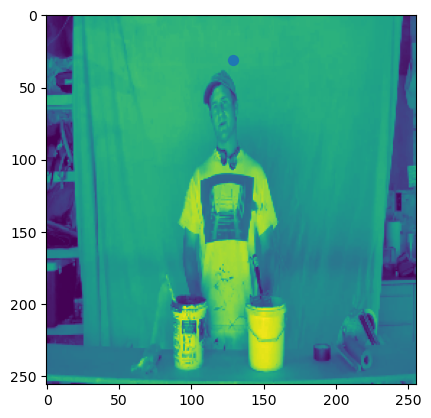

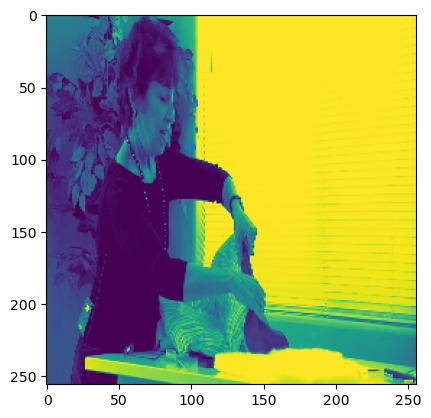

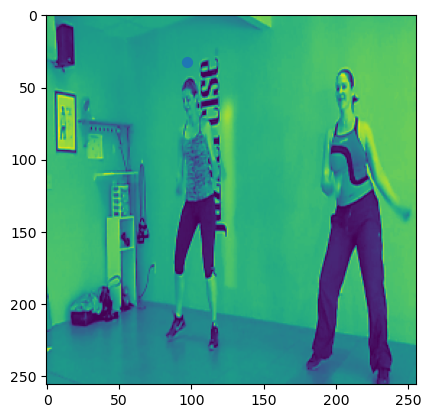

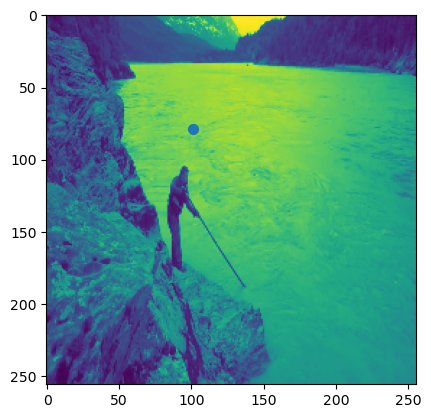

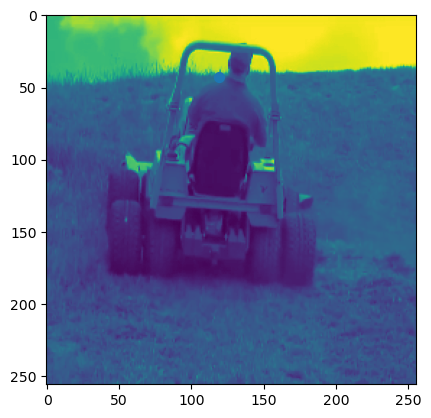

In [ ]:
predict_image(model, test_loader, dev)